# Trabajando con filtrado basado en factorizacion SVD para nuestro sistema de recomendacion basado en productos de Amazon

### Paso 1: Importar las librerias necesarias


In [1]:
import numpy as np
import pandas as pd
import sklearn
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json

from collections import Counter



### Paso 2: Cargando los datos


Los datos se pueden descargar de la siguiente liga en donde se pueden ver todas las categorias que Amazon puede tener en los productos ofrecidos. Para este caso usamos los productos contenidos en la categoria "Handmade Products".

https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

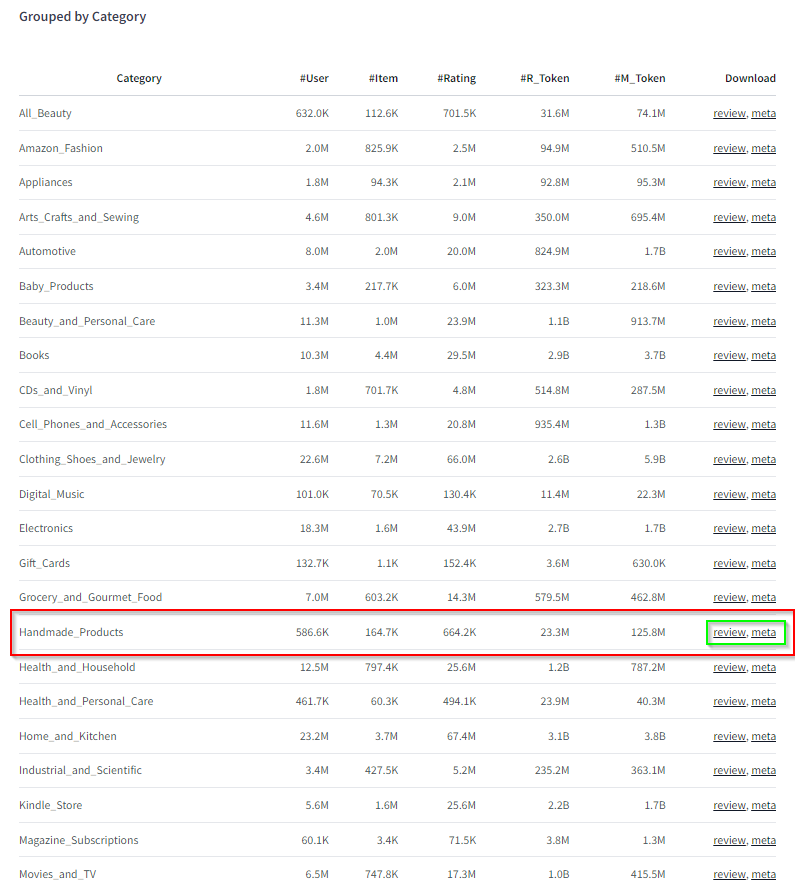

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_jsonl_gz(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

# Cargando los reviews/ratings
reviews = read_jsonl_gz('/content/drive/MyDrive/Maestria MNA/3er_Trimestre/01_Big Data/06_Week 6/Actividad/Handmade_Products.jsonl.gz')

# Cargando las especificaciones de los productos
products = read_jsonl_gz('/content/drive/MyDrive/Maestria MNA/3er_Trimestre/01_Big Data/06_Week 6/Actividad/meta_Handmade_Products.jsonl.gz')

In [4]:
products.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Handmade,Daisy Keychain Wristlet Gray Fabric Key fob La...,4.5,12,"[High Quality Fabrics, Antique Brass Metallic ...",[This charming Daisy Fabric Keychain wristlet ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,"[Handmade Products, Clothing, Shoes & Accessor...",{'Package Dimensions': '8 x 4 x 0.85 inches; 0...,B07NTK7T5P,None
1,Handmade,Anemone Jewelry Beauteous November Birthstone ...,4.1,10,"[Stunning gemstone and detailed design, Bands ...",[Anemone brings this November birthstone ring ...,69.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Anemone Jewelry,"[Handmade Products, Jewelry, Rings, Statement]","{'Department': 'womens', 'Date First Available...",B0751M85FV,None
2,Handmade,Silver Triangle Earrings with Chevron Pattern,5.0,1,[],[These large silver triangles are stamped with...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Zoë Noelle Designs,"[Handmade Products, Jewelry, Earrings, Drop & ...","{'Department': 'Women', 'Date First Available'...",B01HYNE114,None
3,Handmade,"Las Vegas Subway Sign Print - Caesar's, Freemo...",1.0,1,[],[Subway Signs make fabulous wall art. A bit of...,19.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,"[Handmade Products, Home & Kitchen, Artwork, P...","{'Date First Available': 'June 14, 2018'}",B07TKZF3Z1,None
4,Handmade,Round Cut Cubic Zirconia Stud Earrings Fashion...,4.2,2,[⭐【Size】The remarkable cubic zirconia studs ha...,[],14.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],VDKIDKT,"[Handmade Products, Jewelry, Earrings, Stud]",{'Package Dimensions': '2.36 x 2.05 x 1.65 inc...,B0BKBJT5MM,None


### Paso 3: Limpieza y Exploracion de los Datos


In [5]:
#Total productos en el df
products['parent_asin'].nunique()

164817

In [6]:
#Total de productos sin precio
products['price'].isna().sum()

67169

In [7]:
#Borrando records sin precio mostrado
products = products.dropna(subset=['price'])

In [8]:
#Cantidad total nueva de productos
products['parent_asin'].nunique()

97648

In [9]:
#Obteniendo el total de productos con precio debajo de $10 USD para fines de un buen rendimiento de la memoria RAM y para un mejor manejo de datos
len(products['price'][products['price'] < 10])

12065

In [10]:
products = products[products['price'] < 10 ]

In [11]:
#Definiendo el DF solamente para los datos del ID, titulo, precio y categorias
products = products[['parent_asin', 'title', 'price', 'categories']]

In [12]:
#Categorizando en una nueva columna los productos por cada $100 USD
bins = [0, 0.999, 1.999, 2.999, 3.999, 4.999, 5.999, 6.999, 7.999, 8.999, 9.999]
labels = ['<1', '1-1.9', '2-2.9', '3-3.9', '4-4.9', '5-5.9', '6-6.9', '7-7.9', '8-8.9', '9-9.9']

products['price_range'] = pd.cut(products['price'], bins=bins, labels=labels, right=True)

In [13]:
products.head()

,parent_asin,title,price,categories,price_range
5,B0184PPCZK,"Baptism Stickers, First Communion Stickers, Ch...",7.70,"[Handmade Products, Stationery & Party Supplie...",7-7.9
16,B09NMZCP5W,"Looped Wooden Bead Garland Decor, 2Pcs Farmhou...",6.59,"[Handmade Products, Home & Kitchen, Home Décor...",6-6.9
22,B071W2LGY2,"54 Funny Duck Stickers, Party Favor Candy Wrap...",6.39,"[Handmade Products, Stationery & Party Supplie...",6-6.9
32,B07XXLKWJR,Turquoise Damask Design Decorative Single Togg...,7.35,"[Handmade Products, Home & Kitchen, Lighting, ...",7-7.9
38,B01KMOINCA,Guitar Music Decal Vinyl Sticker Playing Jazz ...,3.99,"[Handmade Products, Home & Kitchen, Artwork, W...",3-3.9


In [14]:
contador_categorias = Counter(c for categories in products['categories'] for c in categories if c != "Handmade Products") #Excluyendo Handmade Products ya que todos los productos recaen en esta categoria "madre"
contador_categorias = {category: count for category, count in contador_categorias.items() if count >= 100}
contador_categorias = Counter(contador_categorias)
print(f"Existen {len(contador_categorias)} tipos de categorias.")
contador_categorias

Existen 59 tipos de categorias.


Counter({'Stationery & Party Supplies': 2841,
         'Party Supplies': 901,
         'Party Favors': 327,
         'Home & Kitchen': 5160,
         'Home Décor': 2257,
         'Decorative Accessories': 1409,
         'Ornaments': 373,
         'Decorations': 330,
         'Lighting': 178,
         'Lightswitch Plates': 167,
         'Artwork': 1962,
         'Wall Stickers': 459,
         'Stationery': 1936,
         'Notecards & Greeting Cards': 549,
         'Kitchen & Dining': 624,
         'Sports & Outdoors': 409,
         'Car & Vehicle Accessories': 388,
         'Decals': 385,
         'Pet Supplies': 107,
         'Jewelry': 1437,
         'Body Jewelry': 244,
         'Bakeware': 452,
         'Bakeware Molds & Pans': 152,
         'Clothing, Shoes & Accessories': 616,
         'Luggage & Travel Gear': 498,
         'Key & Identification Accessories': 441,
         'Keychains & Keyrings': 221,
         'Prints': 1254,
         'Electronics Accessories': 393,
         'Lapt

In [15]:
#Imprimiendo las categorias mas comunes que existen entre los productos realizados a mano
print("Top 10 de categorias de productos: \n", contador_categorias.most_common(10))

Top 10 de categorias de productos: 
 [('Home & Kitchen', 5160), ('Stationery & Party Supplies', 2841), ('Home Décor', 2257), ('Artwork', 1962), ('Stationery', 1936), ('Stickers', 1811), ('Jewelry', 1437), ('Decorative Accessories', 1409), ('Prints', 1254), ('Party Supplies', 901)]


<ipython-input-16-bce13b38f517>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories', y='count', data=categories_counts_TOP, palette='rocket')


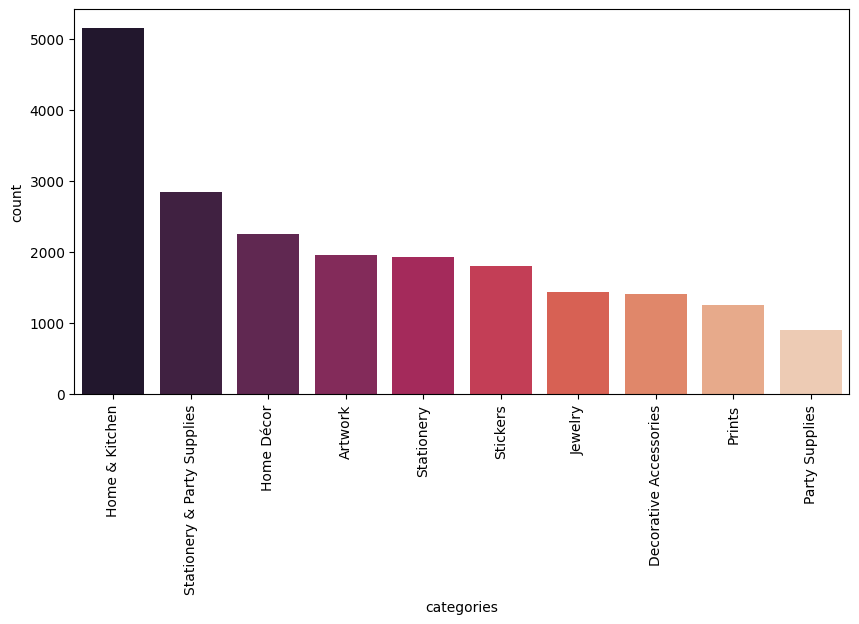

In [16]:
categories_counts = pd.DataFrame([contador_categorias]).T.reset_index()
categories_counts.columns = ['categories', 'count']
categories_counts = categories_counts.sort_values(by='count', ascending=False)
categories_counts_TOP = categories_counts.nlargest(10, 'count') #Visualizando solamente TOP 10

plt.figure(figsize=(10,5))
sns.barplot(x='categories', y='count', data=categories_counts_TOP, palette='rocket')
plt.xticks(rotation=90)
plt.show()

### Paso 4: Transformando los datos

Construyendo el sistema de recomendacion con filtrado basado en contenido teniendo las filas representando los productos y las columnas las categorias y el rango de precio

In [17]:
categories = list(contador_categorias.keys())

for g in categories:
    products[g] = products['categories'].transform(lambda x: int(g in x))

In [18]:
#Visualizando las categorias epor cada columna, se tienen un total de 59 categorias
products[categories].head()

,Stationery & Party Supplies,Party Supplies,Party Favors,Home & Kitchen,Home Décor,Decorative Accessories,Ornaments,Decorations,Lighting,Lightswitch Plates,...,Mixed Media,Piercing Jewelry,Hoops,Drop & Dangle,Pendant,Hair Care,Hair Styling Accessories,Health & Personal Care,Personal Care,Badge Clips & Reels
5,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
product_features = products[categories]

In [20]:
#Aprovechando el uso de la funcion coseno para encontrar el indice de un ID en caso de que sea mal escrito
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(product_features, product_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (12065, 12065)


In [21]:
pip install fuzzywuzzy

In [22]:
#Debido a que los nombres son muy complejos para la categoria de Handmade Products, se usaron los IDs para una mejor busqueda de productos, se arrojaran los titulos de los productos relacionados a ese ID

from fuzzywuzzy import process

def encuentra_producto(id):
    all_ids = products['parent_asin'].tolist()
    closest_match = process.extractOne(id,all_ids)
    return closest_match[0]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [23]:
#Se prueba la funcionalidad de la funcion encuentra_producto() al escribir equivocadamente el ID B071
id = encuentra_producto('B071')
print(f"El ID correcto del producto es: {id}:")

El ID correcto del producto es: B071W2LGY2:


In [24]:
#Se procede a encontrar los indices del ID del producto que se desea analizar, se crea un diccionario llamado product_idx
product_idx = dict(zip(products['parent_asin'], list(products.index)))
idx = product_idx[id]
print(f"El indice del producto {id} en la matriz product_idx es: {idx}")

El indice del producto B071W2LGY2 en la matriz product_idx es: 22


### Paso 5: Construyendo un sistema de recomendacion de "Productos Parecidos" utilizando factorizacion matricial SVD

In [25]:
#convirtiendo el df a matriz y que sea de valores flotantes
products_category_matrix = products[categories].values

In [26]:
products_category_matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
print(products_category_matrix.dtype)

int64


In [28]:
products_category_matrix = products_category_matrix.astype(np.float64)

In [29]:
# Ejecuncion de la Descomposicion Singular de Valores (SVD) con 2 valores latentes
k = 2
U, sigma, Vt = svds(products_category_matrix, k=k)
sigma = np.diag(sigma)

# Reconstruccion de la matriz producto-categoria matrix factorizando las matrices U, sigma, y Vt
predicted_associations = np.dot(np.dot(U, sigma), Vt)

# Obtenemos los productos similares del producto con indice 22
product_index = 22
product_latent_factors = U[product_index]

similarity_scores = cosine_similarity([product_latent_factors], U)[0]

# Rankeamos los productos mas similares
similar_products_indices = np.argsort(similarity_scores)[::-1]

# Imprimimos los productos similares
print("Top productos similares:")
for i in similar_products_indices:
    if i != product_index:  # Ese excluye el indice 22
        print("Producto:", i)

Streaming output truncated to the last 5000 lines.
Producto: 2294
Producto: 5628
Producto: 2667
Producto: 5475
Producto: 11419
Producto: 11595
Producto: 11643
Producto: 11647
Producto: 427
Producto: 156
Producto: 5427
Producto: 255
Producto: 5663
Producto: 11577
Producto: 263
Producto: 2518
Producto: 11700
Producto: 2574
Producto: 5657
Producto: 5404
Producto: 269
Producto: 2575
Producto: 10952
Producto: 5482
Producto: 5490
Producto: 11225
Producto: 11169
Producto: 11116
Producto: 11132
Producto: 235
Producto: 2629
Producto: 234
Producto: 244
Producto: 11145
Producto: 11157
Producto: 11025
Producto: 5529
Producto: 11547
Producto: 2553
Producto: 11176
Producto: 2622
Producto: 5739
Producto: 5513
Producto: 5748
Producto: 11202
Producto: 11535
Producto: 11540
Producto: 133
Producto: 266
Producto: 5376
Producto: 5885
Producto: 5641
Producto: 5301
Producto: 461
Producto: 5285
Producto: 10791
Producto: 11271
Producto: 11972
Producto: 522
Producto: 2736
Producto: 5308
Producto: 2744
Producto: